In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
import numpy as np

from model import MLP, MLP_RES, CNN_RES
from dataset import BurgersDatasetBPTTsubdomain, BurgersDatasetBPTT, train_split_files

from utils import clear_memory

from config import *
from train import loss_w_gradient, unroll_loss, train_bptt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from utils import clear_memory
from model import pad_with_ghost_cells

LR = 1e-3
EPOCHS = 150
NUM_STEPS_PER_EPOCH = 300
EARLY_STOPPING = 50

# checkpoint_name = "best_CNN_RES_UNROLL_5"
checkpoint_name = None
fine_tune = False # continue training the same model

unroll_array =[1, 2, 3, 5, 7] # 5, 7, 10, 15, 20, 30, 40, 50]


for UNROLL_STEPS in unroll_array:
    print(f"Training with unroll steps: {UNROLL_STEPS}")
    print(f"Learning Rate: {LR}")

    # ---------------------------------------------------------------- #

    train_files, val_files = train_split_files()
    train_files = train_files
    val_files = val_files
    
    # Have to recreate datasets and dataloaders for each unroll steps

    train_dataset = BurgersDatasetBPTTsubdomain(file_paths=train_files, unroll_steps=UNROLL_STEPS)
    val_dataset = BurgersDatasetBPTTsubdomain(file_paths=val_files, unroll_steps=UNROLL_STEPS)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # ---------------------------------------------------------------- #

    model = CNN_RES(
        hidden_channels=HIDDEN_SIZE,
        num_blocks=NUM_RES_BLOCKS,
        kernel_size=KERNEL_SIZE,
        activation=nn.ReLU,
        ghost_cells=GHOST_CELLS
    )

    # model = MLP_RES(
    #     input_size=INPUT_SIZE,
    #     hidden_size=HIDDEN_SIZE,
    #     output_size=OUTPUT_SIZE,
    #     num_blocks=NUM_RES_BLOCKS,
    #     activation=nn.ReLU
    # )

    # model = MLP(
    #     input_size=INPUT_SIZE,
    #     hidden_size=HIDDEN_SIZE,
    #     output_size=OUTPUT_SIZE,
    #     activation=nn.ReLU
    # )
    
    if checkpoint_name is not None:
        model.load_state_dict(torch.load(f"models/{checkpoint_name}.pth", weights_only=True), strict=False) # pre-trained model
    model.to(device)

    # criterion = nn.MSELoss()
    criterion = loss_w_gradient  # use custom loss with gradient term
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-11)

    # model_name = "CNN_RES_UNROLL_" + str(UNROLL_STEPS)
    model_name = "MLP_UNROLL_" + str(UNROLL_STEPS)
    checkpoint_name = model_name

    if not os.path.exists(f"models/{model_name}.pth") or fine_tune:
        loss_history = train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, UNROLL_STEPS, EPOCHS, EARLY_STOPPING, NUM_STEPS_PER_EPOCH, model_name=model_name)
        torch.save(model.state_dict(), f"models/{model_name}.pth")
        print(f"Model saved")

        last_lr = loss_history["best_lr"]
        clamp = lambda x_padded, min_v, max_v: max(min_v, min(x_padded, max_v))
        LR = clamp(last_lr*2, 1e-8, 1e-5) # LR for next model

        if not os.path.exists(f"models/loss_{model_name}.png"):
            #save loss_history to file
            with open(f"models/loss_{model_name}.txt", "w") as f:
                for key, values in loss_history.items():
                    f.write(f"{key}: {values}\n")

            plt.figure(figsize=(8, 4), dpi=300)
            plt.plot(loss_history["train"], label="Train Loss")
            plt.plot(loss_history["val"], label="Val Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Unroll steps = {UNROLL_STEPS}")
            plt.yscale("log")
            plt.tight_layout()
            plt.grid(which="both", linestyle="--", linewidth=0.5)
            plt.legend()
            plt.ylim(1e-4, 1e-0)
            plt.tight_layout()
            plt.savefig(f"models/loss_{model_name}.png")
            plt.show()

    else:
        model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True), strict=False)
        model.eval()
        print("Model loaded")

    # ---------------------------------------------------------------- #

    #evaluate model on val_loader
    val_loss = 0.0
    with torch.no_grad():
        for x_padded, y_padded in val_loader:
            x_padded = x_padded.to(device)
            y_padded = y_padded.to(device)
            loss = unroll_loss(x_padded, y_padded, model, unroll_steps=UNROLL_STEPS, eval=True)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Model validation Loss over {UNROLL_STEPS} steps: {avg_val_loss:.4e}")

    clear_memory()

Training with unroll steps: 1
Learning Rate: 0.001
Found 200 simulations.
Splitting into 140 training and 60 validation files.
Model loaded


KeyboardInterrupt: 

Model unroll steps 1 validation Loss over full sequence: 2.4101e-01
Model unroll steps 2 validation Loss over full sequence: 2.0967e-01
Model unroll steps 3 validation Loss over full sequence: 2.0455e-01


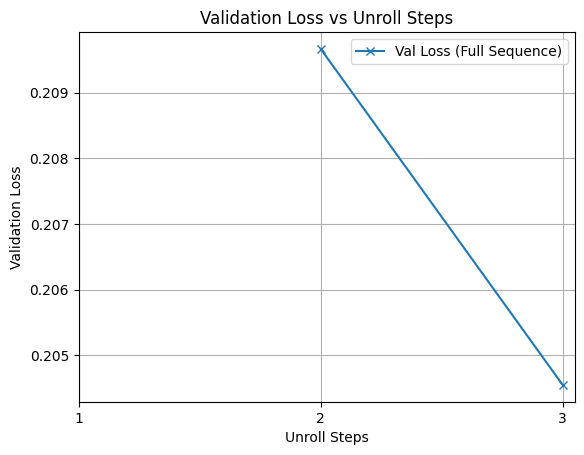

In [12]:
to_remove = []

# full rollout
val_dataset = BurgersDatasetBPTTsubdomain(file_paths=val_files, unroll_steps=-1)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_loss_array = []
val_loss_full_array = []
for UNROLL_STEPS in unroll_array:
    # model_name = "CNN_RES_UNROLL_" + str(UNROLL_STEPS)
    model_name = "MLP_UNROLL_" + str(UNROLL_STEPS)
    if os.path.exists(f"models/{model_name}.pth"):
        model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True))
        model.eval()

        val_loss = 0.0
        with torch.no_grad():
            for x_padded, y_padded in val_loader:
                x_padded = x_padded.to(device)
                y_padded = y_padded.to(device)
                loss = unroll_loss(x_padded, y_padded, model, unroll_steps=-1, eval=True)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_full_array.append(avg_val_loss)
        print(f"Model unroll steps {str(UNROLL_STEPS)} validation Loss over full sequence: {avg_val_loss:.4e}")
    else:
        to_remove.append(UNROLL_STEPS)

unroll_array = [u for u in unroll_array if u not in to_remove]


plt.plot(unroll_array[1:], val_loss_full_array[1:], marker='x', label='Val Loss (Full Sequence)')
plt.xticks(unroll_array)
plt.xlabel("Unroll Steps")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Unroll Steps")
plt.legend()
plt.grid()
plt.show()

In [13]:
UNROLL_STEPS = 3
# checkpoint_name = f"CNN_RES_UNROLL_{UNROLL_STEPS}.pth"
checkpoint_name = f"MLP_UNROLL_{UNROLL_STEPS}.pth"
model.load_state_dict(torch.load(f"models/{checkpoint_name}", weights_only=True))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=162, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=160, bias=True)
  )
)

torch.Size([64, 162]) torch.Size([64, 1, 162])
torch.Size([64, 162]) torch.Size([64, 1, 162])


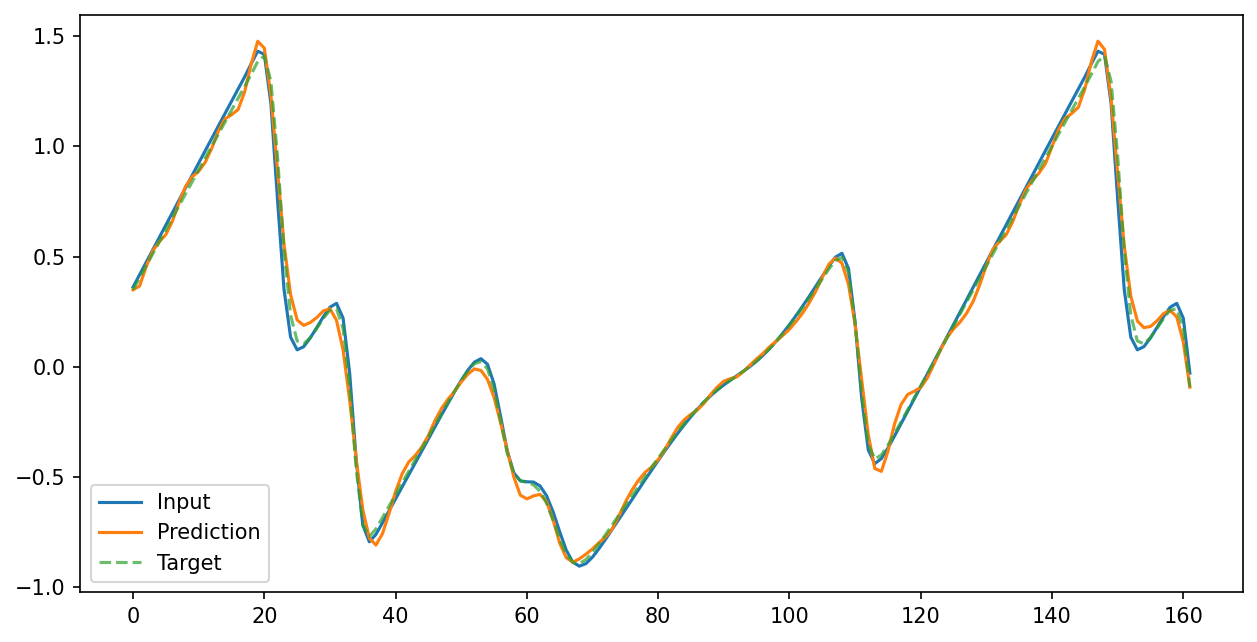

In [14]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

print(x.shape, y.shape)

with torch.no_grad():
	y_pred = model(x)
	y_pred_padded = pad_with_ghost_cells(y_pred, y[:, 0, :GHOST_CELLS//2], y[:, 0, -GHOST_CELLS//2:])
	
	
# y_pred = y_pred.cpu()
y_pred = y_pred_padded.cpu()
x = x.cpu()
y = y.cpu()

print(y_pred.shape, y.shape)
#plot 
plt.figure(figsize=(10,5), dpi=150)
plt.plot(x[0].numpy(), label='Input')
plt.plot(y_pred[0], label='Prediction')
plt.plot(y[0][0].numpy(), label='Target', alpha=0.7, linestyle='--')
plt.legend()

Rollout MSE over 100 steps: 2.1052e-01


/tmp/ipykernel_72884/3113733472.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.875]) # Adjust layout to make space for the main title


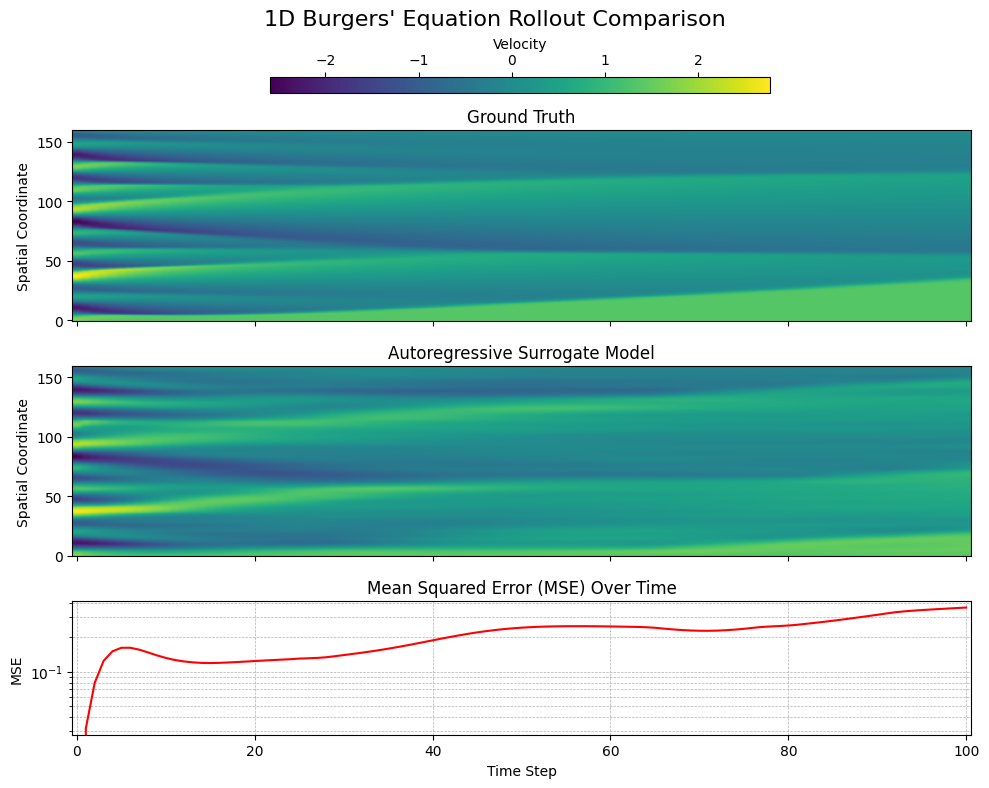

In [15]:
import numpy as np
import os

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['Solver-Mesh-1D-Internal']

rollout_steps = raw_data.shape[0] - 1

start_index = 0

INPUT_SIZE = 162

# x_offset = np.random.randint(0, INPUT_SIZE - GHOST_CELLS)
# print(f"x_offset: {x_offset}")
x_offset = 0

ground_truth_padded = raw_data[start_index : start_index + rollout_steps + 1, x_offset:x_offset+INPUT_SIZE]
ground_truth = ground_truth_padded[:, GHOST_CELLS//2:-GHOST_CELLS//2]
x0_np = ground_truth[0]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0).to(device)

with torch.no_grad():
    for i in range(rollout_steps):
        # bc_left = current_x[:, -1:]
        # bc_right = current_x[:, :1]
        bc_left = ground_truth_padded[i+1, :GHOST_CELLS//2]
        bc_right = ground_truth_padded[i+1, -GHOST_CELLS//2:]

        bc_left = torch.from_numpy(np.array([bc_left])).float().to(device)
        bc_right = torch.from_numpy(np.array([bc_right])).float().to(device)
        
        padded_input = pad_with_ghost_cells(current_x, bc_left, bc_right)

        y_pred = model(padded_input)

        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)
mse = np.mean((predictions - ground_truth)**2)

# --- 1. Calculate all necessary data for plotting ---
mse_over_steps = np.mean((predictions - ground_truth)**2, axis=1)
print(f"Rollout MSE over {rollout_steps} steps: {mse_over_steps.mean():.4e}")

# Determine the shared color limits
vmin = ground_truth.min()
vmax = ground_truth.max()


# --- 2. Create a 3x1 subplot layout with a shared X-axis ---
# The key change is sharex=True, which links the x-axes of all subplots.
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True,
                         gridspec_kw={'height_ratios': [1, 1, 0.7]}) # Give less height to the MSE plot

# --- Plot 1: Ground Truth (now on top) ---
im = axes[0].imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_ylabel('Spatial Coordinate')

# --- Plot 2: Surrogate Rollout (in the middle) ---
axes[1].imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax, cmap='viridis')
axes[1].set_title('Autoregressive Surrogate Model')
axes[1].set_ylabel('Spatial Coordinate')

# --- Plot 3: MSE over Time Steps (at the bottom) ---
axes[2].plot(mse_over_steps, color='r')
axes[2].set_title('Mean Squared Error (MSE) Over Time')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('MSE')
axes[2].set_yscale("log")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)
# Set explicit x-axis limits to match the imshow extent
axes[2].set_xlim(-0.5, len(mse_over_steps) - 0.5)

# --- THE KEY CHANGES START HERE ---

# --- 3. Manually create a new axis for the colorbar ---
# The rectangle's coordinates are in "figure fractions" (0 to 1).
# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.275, 0.875, 0.5, 0.02]) # Positioned at the top

# --- 4. Draw the colorbar into the new axis using the `cax` argument ---
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Velocity')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')


fig.tight_layout(rect=[0, 0, 1, 0.875]) # Adjust layout to make space for the main title
fig.suptitle(f"1D Burgers' Equation Rollout Comparison", fontsize=16)

# Save and show the combined figure
plt.savefig('rollout_comparison.svg', dpi=300)
plt.show()

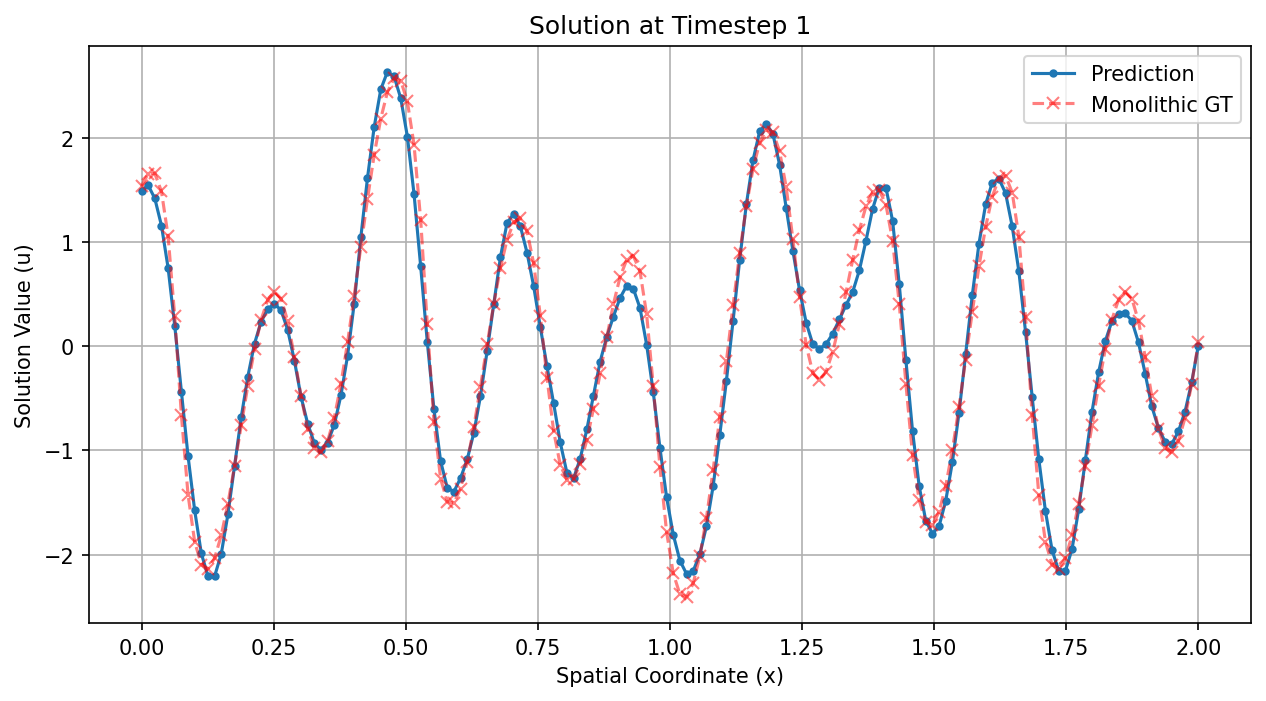

In [18]:
TIMESTEP_TO_PLOT = 1

x_coords = np.linspace(0, 2, len(ground_truth[0]))

# --- plot single timestep ---
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(x_coords, predictions[TIMESTEP_TO_PLOT, :], marker='.', linestyle='-', label='Prediction')
plt.plot(x_coords, ground_truth[TIMESTEP_TO_PLOT, :], marker='x', linestyle='--', alpha=0.5, c="red", label='Monolithic GT')
plt.title(f'Solution at Timestep {TIMESTEP_TO_PLOT}')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Solution Value (u)')
plt.grid(True)
plt.legend()

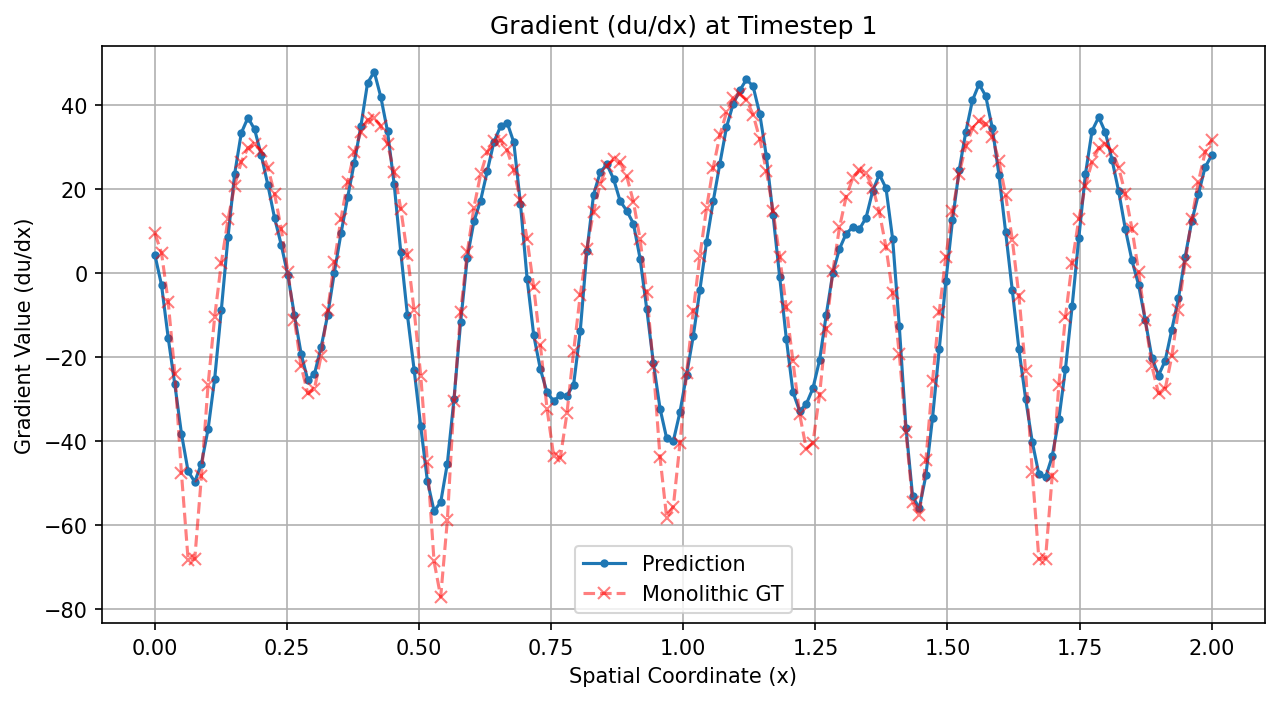

In [19]:
# --- plot gradient at single timestep ---
solution_slice = predictions[TIMESTEP_TO_PLOT, :]
du_dx = np.gradient(solution_slice, x_coords)

plt.figure(figsize=(10, 5), dpi=150)
plt.plot(x_coords, du_dx, marker='.', linestyle='-', label='Prediction')

solution_gt_slice = ground_truth[TIMESTEP_TO_PLOT, :]
du_dx_gt = np.gradient(solution_gt_slice, x_coords)
plt.plot(x_coords, du_dx_gt, marker='x', linestyle='--', alpha=0.5, c="red", label='Monolithic GT')

plt.title(f'Gradient (du/dx) at Timestep {TIMESTEP_TO_PLOT}')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Gradient Value (du/dx)')
plt.grid(True)
plt.legend()